# Loading the Data

In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import shap
import cfbd
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('t_ds', 'tds'))
    return cols_new

In [4]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [5]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in range(2012, 2025): # Adjusted to include 2012 for rolling window
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2012.parquet from cached data
Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo,start_date
0,322432710,2012,1,regular,True,False,3746.0,2710,Western Illinois,MVFC,fcs,23.0,NaN,2086,Butler,Pioneer,fcs,15.0,NaN,NaT
1,322432117,2012,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,38.0,NaN,2546,Southeast Missouri State,OVC,fcs,27.0,NaN,NaT
2,322432050,2012,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,37.0,1299.0,2199,Eastern Michigan,Mid-American,fbs,26.0,1231.0,NaT
3,322432006,2012,1,regular,True,False,3768.0,2006,Akron,Mid-American,fbs,14.0,997.0,2116,UCF,Conference USA,fbs,56.0,1559.0,NaT
4,322430238,2012,1,regular,True,False,3973.0,238,Vanderbilt,SEC,fbs,13.0,1573.0,2579,South Carolina,SEC,fbs,17.0,1743.0,NaT


In [6]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.columns = plays.columns.str.replace('t_ds', 'tds', regex=False)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [7]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [8]:
game_team_stats_dir = join(DATA_DIR, 'game_team_stats')
if not os.path.exists(game_team_stats_dir):
    os.makedirs(game_team_stats_dir)

def flatten_team_data(row):
    game_id = row['id']
    teams_data = row['teams']
    
    # Parse the JSON string if it's not already parsed
    if isinstance(teams_data, str):
        teams_data = json.loads(teams_data)
    
    rows = []
    for team in teams_data:
        # Create base dictionary with non-stats fields
        team_row = {
            'game_id': game_id,
            'teamId': team['teamId'],
            'team': team['team'],
            'conference': team['conference'],
            'homeAway': team['homeAway'],
            'points': team['points']
        }
        
        # Add stats fields
        for stat in team['stats']:
            # Convert stat names to valid column names if needed
            col_name = stat['category']
            team_row[col_name] = stat['stat']
        
        rows.append(team_row)
    
    return rows

all_dfs = []
for year in range(2012, 2025): # Include year prior to 2013 for rolling stats
    file_path = join(DATA_DIR, 'game_team_stats', f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
        all_dfs.append(tmp)
    else:
        weeks = games.query('season == @year').week.unique().tolist()
        if not weeks:
            weeks = range(1, 16)

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} team stats data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.GamesApi(api_client)
                data = api_instance.get_game_team_stats(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                games_count = games.query('season == @year and week == @week and home_division == "fbs"').shape[0] + \
                    games.query('season == @year and week == @week and away_division == "fbs"').shape[0]
                print(f'No team stats data for {year} week {week}, number of FBS teams: {games_count}')
                continue

            flattened_data = []
            for _, row in tmp.iterrows():
                flattened_data.extend(flatten_team_data(row))
            result_df = pd.DataFrame(flattened_data)

            base_columns = ['game_id', 'teamId', 'team', 'conference', 'homeAway', 'points']
            stat_columns = [col for col in result_df.columns if col not in base_columns]
            result_df = result_df[base_columns + stat_columns]
            result_df.columns = convert_to_snake_case(result_df.columns)
            season_dfs.append(result_df)

        season_df = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)

        all_dfs.append(season_df)
        season_df.to_parquet(file_path)

team_stats = (
    games[['id', 'season', 'week', 'season_type']].rename(columns={'id': 'game_id'})
    .merge(
        pd.concat(all_dfs, ignore_index=True).reset_index(drop=True),
        on='game_id', how='left'
    )
    .dropna(subset=['team_id'])
    .sort_values(
        by=['season', 'season_type', 'week', 'team_id'], 
        ignore_index=True, 
        ascending=[True, False, True, True]
    )
)
team_stats.head()

Reading ../data/game_team_stats/2012.parquet from cached data
Reading ../data/game_team_stats/2013.parquet from cached data
Reading ../data/game_team_stats/2014.parquet from cached data
Reading ../data/game_team_stats/2015.parquet from cached data
Reading ../data/game_team_stats/2016.parquet from cached data
Reading ../data/game_team_stats/2017.parquet from cached data
Reading ../data/game_team_stats/2018.parquet from cached data
Reading ../data/game_team_stats/2019.parquet from cached data
Reading ../data/game_team_stats/2020.parquet from cached data
Reading ../data/game_team_stats/2021.parquet from cached data
Reading ../data/game_team_stats/2022.parquet from cached data
Reading ../data/game_team_stats/2023.parquet from cached data
Reading ../data/game_team_stats/2024.parquet from cached data


,game_id,season,week,season_type,team_id,team,conference,home_away,points,possession_time,interceptions,fumbles_lost,turnovers,total_penalties_yards,yards_per_rush_attempt,rushing_attempts,rushing_yards,yards_per_pass,completion_attempts,net_passing_yards,total_yards,fourth_down_eff,third_down_eff,first_downs,passes_intercepted,interception_tds,interception_yards,kicking_points,kick_returns,kick_return_tds,kick_return_yards,passing_tds,punt_returns,punt_return_tds,punt_return_yards,rushing_tds,fumbles_recovered,passes_deflected,qb_hurries,sacks,tackles,defensive_tds,tackles_for_loss,total_fumbles
0,322450002,2012,1,regular,2.0,Auburn,SEC,home,19.0,28:14,1,1,2,6-38,4.9,37,180,7.2,11-27,194,374,0-1,4-13,17,1,0,12,13,1,0,21,1,1,0,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,322450005,2012,1,regular,5.0,UAB,Conference USA,home,29.0,41:39,1,3,4,9-47,3.0,44,134,9.6,19-34,325,459,0-2,8-16,23,None,None,None,5,5,0,82,2,3,0,-6,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,322450006,2012,1,regular,6.0,South Alabama,Sun Belt,home,31.0,26:53,1,3,4,7-80,3.4,37,126,7.0,15-26,182,308,2-2,5-13,18,1,0,28,7,2,0,95,2,2,0,37,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,322450008,2012,1,regular,8.0,Arkansas,SEC,home,49.0,25:41,0,3,3,6-38,4.7,35,164,11.8,23-34,400,564,0-2,5-9,25,None,None,None,7,4,0,96,3,5,0,29,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,322430009,2012,1,regular,9.0,Arizona State,Pac-12,home,63.0,30:16,0,1,1,4-30,6.0,51,305,12.4,16-20,249,554,1-1,7-13,25,3,1,117,9,1,0,7,1,2,0,13,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
advanced_team_stats_dir = join(DATA_DIR, 'advanced_team_stats')
if not os.path.exists(advanced_team_stats_dir):
    os.makedirs(advanced_team_stats_dir)

def parse_stats(row):
    offense = row['offense']
    defense = row['defense']
    return pd.Series({
        'offense_ppa': offense.get('ppa'),
        'offense_successRate': offense.get('successRate'),
        'offense_explosiveness': offense.get('explosiveness'),
        'offense_passingPlays_ppa': offense.get('passingPlays', {}).get('ppa'),
        'offense_passingPlays_successRate': offense.get('passingPlays', {}).get('successRate'),
        'offense_passingPlays_explosiveness': offense.get('passingPlays', {}).get('explosiveness'),
        'offense_rushingPlays_ppa': offense.get('rushingPlays', {}).get('ppa'),
        'offense_rushingPlays_successRate': offense.get('rushingPlays', {}).get('successRate'),
        'offense_rushingPlays_explosiveness': offense.get('rushingPlays', {}).get('explosiveness'),
        'defense_ppa': defense.get('ppa'),
        'defense_successRate': defense.get('successRate'),
        'defense_explosiveness': defense.get('explosiveness'),
        'defense_passingPlays_ppa': defense.get('passingPlays', {}).get('ppa'),
        'defense_passingPlays_successRate': defense.get('passingPlays', {}).get('successRate'),
        'defense_passingPlays_explosiveness': defense.get('passingPlays', {}).get('explosiveness'),
        'defense_rushingPlays_ppa': defense.get('rushingPlays', {}).get('ppa'),
        'defense_rushingPlays_successRate': defense.get('rushingPlays', {}).get('successRate'),
        'defense_rushingPlays_explosiveness': defense.get('rushingPlays', {}).get('explosiveness')
    })

all_dfs = []
for year in range(2012, 2025): # Include year prior to 2013 for rolling stats
    file_path = join(DATA_DIR, 'advanced_team_stats', f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
        all_dfs.append(tmp)
    else:
        regular_weeks = team_stats.query('season == @year and season_type=="regular"').week.unique().tolist()
        postseason_weeks = team_stats.query('season == @year and season_type=="postseason"').week.unique().tolist()

        season_dfs = []
        for season_type in ['regular', 'postseason']:
            weeks = regular_weeks if season_type == 'regular' else postseason_weeks
            for week in weeks:
                print(f'Fetching {year} team stats data for {season_type} week {week} from CFBD API')
                with cfbd.ApiClient(configuration) as api_client:
                    api_instance = cfbd.StatsApi(api_client)
                    data = api_instance.get_advanced_game_stats(
                        year=year,
                        week=week,
                        season_type=cfbd.SeasonType(season_type)
                    )
                tmp = pd.DataFrame([val.to_dict() for val in data])
                
                result_df = (
                    tmp.join(tmp.apply(parse_stats, axis=1))
                    .drop(columns=['offense', 'defense', 'opponent'])
                    .assign(season_type=season_type)
                )

                result_df.columns = convert_to_snake_case(result_df.columns)

                base_columns = ['game_id', 'season', 'team', 'season_type']
                stat_columns = [col for col in result_df.columns if col not in base_columns]
                result_df = result_df[base_columns + stat_columns]
                season_dfs.append(result_df)

            season_df = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)

            all_dfs.append(season_df)
            season_df.to_parquet(file_path)

advanced_team_stats = (
    pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
    .sort_values(
        by=['team', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
)
advanced_team_stats.head()

Reading ../data/advanced_team_stats/2012.parquet from cached data
Reading ../data/advanced_team_stats/2013.parquet from cached data
Reading ../data/advanced_team_stats/2014.parquet from cached data
Reading ../data/advanced_team_stats/2015.parquet from cached data
Reading ../data/advanced_team_stats/2016.parquet from cached data
Reading ../data/advanced_team_stats/2017.parquet from cached data
Reading ../data/advanced_team_stats/2018.parquet from cached data
Reading ../data/advanced_team_stats/2019.parquet from cached data
Reading ../data/advanced_team_stats/2020.parquet from cached data
Reading ../data/advanced_team_stats/2021.parquet from cached data
Reading ../data/advanced_team_stats/2022.parquet from cached data
Reading ../data/advanced_team_stats/2023.parquet from cached data
Reading ../data/advanced_team_stats/2024.parquet from cached data


,game_id,season,team,season_type,week,offense_ppa,offense_success_rate,offense_explosiveness,offense_passing_plays_ppa,offense_passing_plays_success_rate,offense_passing_plays_explosiveness,offense_rushing_plays_ppa,offense_rushing_plays_success_rate,offense_rushing_plays_explosiveness,defense_ppa,defense_success_rate,defense_explosiveness,defense_passing_plays_ppa,defense_passing_plays_success_rate,defense_passing_plays_explosiveness,defense_rushing_plays_ppa,defense_rushing_plays_success_rate,defense_rushing_plays_explosiveness
0,332990166,2013,Abilene Christian,regular,9,0.223948,0.442857,1.110309,0.325306,0.500000,1.196165,0.078084,0.304348,1.141636,0.199207,0.534247,0.845228,0.504164,0.620690,1.135052,0.025083,0.452381,0.719215
1,400548403,2014,Abilene Christian,regular,1,0.258485,0.461538,1.287510,0.590613,0.547619,1.721632,-0.134873,0.323529,0.619187,0.287588,0.518072,1.261359,0.447216,0.450980,1.953486,0.074896,0.612903,0.556223
2,400548413,2014,Abilene Christian,regular,3,0.367337,0.460526,1.425814,0.719482,0.527778,1.754093,0.073443,0.384615,1.161582,0.365256,0.424242,1.492707,0.281203,0.315789,1.973852,0.479327,0.571429,1.131849
3,400799923,2015,Abilene Christian,regular,1,-0.040340,0.324324,1.093651,-0.003188,0.380000,1.173526,-0.117741,0.208333,0.790128,0.171840,0.458824,1.156626,0.097262,0.355556,1.511928,0.259238,0.552632,0.978046
4,400869175,2016,Abilene Christian,regular,1,0.209173,0.301587,1.920856,0.530104,0.323529,2.711378,-0.167092,0.275862,0.833889,0.307413,0.481013,1.197367,1.031893,0.500000,2.860137,0.192573,0.469697,0.940196


In [ ]:
team_stats = (
    team_stats
    .sort_values(
        by=['team_id', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
    .assign(
        completion_attempts=lambda x: x.completion_attempts.fillna('0-0')
    )
    .assign(
        pass_attempts=lambda x: np.where(
            x.completion_attempts.str.split('-').str.len() == 2,
            x.completion_attempts.str.split('-').str[1],
            np.nan
        ).astype(int),
        rushing_attempts=lambda x: x.rushing_attempts.astype(float),
        rushing_yards=lambda x: x.rushing_yards.astype(float),
        net_passing_yards=lambda x: x.net_passing_yards.astype(float),
        kicking_points=lambda x: x.kicking_points.astype(float),
    )
    .rename(columns={'net_passing_yards': 'passing_yards'})
)

median_passing_attempts = team_stats.query('pass_attempts > 0').pass_attempts.median(skipna=True)
median_passing_yards = team_stats.query('pass_attempts > 0').passing_yards.median(skipna=True)
median_rushing_attempts = team_stats.query('rushing_attempts > 0').rushing_attempts.median(skipna=True)
median_rushing_yards = team_stats.query('rushing_attempts > 0').rushing_yards.median(skipna=True)

cols = [
    'game_id', 'season', 'week', 'season_type', 'team_id', 'team',
    'rushing_attempts', 'rushing_yards',
    'pass_attempts', 'passing_yards',
    'kicking_points'
]

team_stats = (
    team_stats
    .assign(
        pass_attempts=np.where(
            team_stats.pass_attempts > 0,
            team_stats.pass_attempts,
            median_passing_attempts
        ),
        passing_yards=np.where(
            (team_stats.passing_yards > 0) & team_stats.passing_yards.notnull(),
            team_stats.passing_yards,
            median_passing_yards
        ),
        rushing_attempts=np.where(
            (team_stats.rushing_attempts > 0) & team_stats.rushing_attempts.notnull(),
            team_stats.rushing_attempts,
            median_rushing_attempts
        ),
        rushing_yards=np.where(
            (team_stats.rushing_yards > 0) & team_stats.rushing_yards.notnull(),
            team_stats.rushing_yards,
            median_rushing_yards
        ),
        kicking_points=lambda x: x.kicking_points.fillna(0).astype(float)
    )
    [cols]
    .dropna(subset=['team_id', 'team', 'season', 'week', 'game_id'])
    .reset_index(drop=True)
)
team_stats.head()

,game_id,season,week,season_type,team_id,team,rushing_attempts,rushing_yards,pass_attempts,passing_yards,kicking_points
0,322450002,2012,1,regular,2.0,Auburn,37.0,180.0,27.0,194.0,13.0
1,322450005,2012,1,regular,5.0,UAB,44.0,134.0,34.0,325.0,5.0
2,322450006,2012,1,regular,6.0,South Alabama,37.0,126.0,26.0,182.0,7.0
3,322450008,2012,1,regular,8.0,Arkansas,35.0,164.0,34.0,400.0,7.0
4,322430009,2012,1,regular,9.0,Arizona State,51.0,305.0,20.0,249.0,9.0


In [11]:
team_stats_joined = (
    team_stats.merge(
        advanced_team_stats.drop(columns=['season', 'week', 'season_type']),
        on=['game_id', 'team'],
        how='left'
    ).sort_values(
        by=['team_id', 'season', 'season_type', 'week'], 
        ignore_index=False, 
        ascending=[True, True, False, True]
    )
    .dropna(subset=[
        'rushing_attempts', 'rushing_yards', 'pass_attempts', 'passing_yards', 'kicking_points',
        'offense_ppa', 'defense_ppa', 
        'offense_passing_plays_ppa', 'offense_passing_plays_success_rate',
        'offense_passing_plays_explosiveness', 'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate', 'offense_rushing_plays_explosiveness',
        'defense_passing_plays_ppa', 'defense_passing_plays_success_rate',
        'defense_passing_plays_explosiveness', 'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate', 'defense_rushing_plays_explosiveness'
    ])
)

rolling_stats_last6 = (
    team_stats_joined[[
        'team_id', 'offense_ppa', 'defense_ppa',
        'rushing_attempts', 'rushing_yards',
        'pass_attempts', 'passing_yards', 'kicking_points',
        'offense_passing_plays_ppa', 'offense_passing_plays_success_rate',
        'offense_passing_plays_explosiveness', 'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate', 'offense_rushing_plays_explosiveness',
        'defense_passing_plays_ppa', 'defense_passing_plays_success_rate',
        'defense_passing_plays_explosiveness', 'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate', 'defense_rushing_plays_explosiveness'
    ]]
    .groupby('team_id')
    .shift(1)
    .rolling(window=6, min_periods=6)
    .sum()
)

rolling_stats_last6 = (
    team_stats[['game_id', 'season', 'week', 'season_type', 'team_id', 'team']]
    .merge(
        rolling_stats_last6.rename(columns={
            'offense_ppa': 'last6_offense_ppa',
            'defense_ppa': 'last6_defense_ppa',
            'rushing_attempts': 'last6_offense_rush_att',
            'rushing_yards': 'last6_offense_rush_yds',
            'pass_attempts': 'last6_offense_pass_att',
            'passing_yards': 'last6_offense_pass_yds',
            'kicking_points': 'last6_kicking_pts',
            'offense_passing_plays_ppa': 'last6_offense_passing_plays_ppa',
            'offense_passing_plays_success_rate': 'last6_offense_passing_plays_success_rate',
            'offense_passing_plays_explosiveness': 'last6_offense_passing_plays_explosiveness',
            'offense_rushing_plays_ppa': 'last6_offense_rushing_plays_ppa',
            'offense_rushing_plays_success_rate': 'last6_offense_rushing_plays_success_rate',
            'offense_rushing_plays_explosiveness': 'last6_offense_rushing_plays_explosiveness',
            'defense_passing_plays_ppa': 'last6_defense_passing_plays_ppa',
            'defense_passing_plays_success_rate': 'last6_defense_passing_plays_success_rate',
            'defense_passing_plays_explosiveness': 'last6_defense_passing_plays_explosiveness',
            'defense_rushing_plays_ppa': 'last6_defense_rushing_plays_ppa',
            'defense_rushing_plays_success_rate': 'last6_defense_rushing_plays_success_rate',
            'defense_rushing_plays_explosiveness': 'last6_defense_rushing_plays_explosiveness' 
        }),
        left_index=True,
        right_index=True,
        how='left'
    )
    .dropna(subset=['last6_offense_rush_att'])
    .query('season >= 2013')
    .reset_index(drop=True)
    .assign(
        last6_pass_to_rush_ratio=lambda x: round(x.last6_offense_pass_att / x.last6_offense_rush_att, 3),
        last6_yards_per_rush=lambda x: round(x.last6_offense_rush_yds / x.last6_offense_rush_att, 1),
        last6_yards_per_pass=lambda x: round(x.last6_offense_pass_yds / x.last6_offense_pass_att, 1),
        last6_offense_passing_plays_ppa=lambda x: round(x.last6_offense_passing_plays_ppa / 6, 3),
        last6_offense_passing_plays_success_rate=lambda x: round(x.last6_offense_passing_plays_success_rate / 6, 3),
        last6_offense_passing_plays_explosiveness=lambda x: round(x.last6_offense_passing_plays_explosiveness / 6, 3),
        last6_offense_rushing_plays_ppa=lambda x: round(x.last6_offense_rushing_plays_ppa / 6, 3),
        last6_offense_rushing_plays_success_rate=lambda x: round(x.last6_offense_rushing_plays_success_rate / 6, 3),
        last6_offense_rushing_plays_explosiveness=lambda x: round(x.last6_offense_rushing_plays_explosiveness / 6, 3),
        last6_defense_passing_plays_ppa=lambda x: round(x.last6_defense_passing_plays_ppa / 6, 3),
        last6_defense_passing_plays_success_rate=lambda x: round(x.last6_defense_passing_plays_success_rate / 6, 3),
        last6_defense_passing_plays_explosiveness=lambda x: round(x.last6_defense_passing_plays_explosiveness / 6, 3),
        last6_defense_rushing_plays_ppa=lambda x: round(x.last6_defense_rushing_plays_ppa / 6, 3),
        last6_defense_rushing_plays_success_rate=lambda x: round(x.last6_defense_rushing_plays_success_rate / 6, 3),
        last6_defense_rushing_plays_explosiveness=lambda x: round(x.last6_defense_rushing_plays_explosiveness / 6, 3)
    )
)

del team_stats_joined

rolling_stats_last6.head()

,game_id,season,week,season_type,team_id,team,last6_offense_ppa,last6_defense_ppa,last6_offense_rush_att,last6_offense_rush_yds,last6_offense_pass_att,last6_offense_pass_yds,last6_kicking_pts,last6_offense_passing_plays_ppa,last6_offense_passing_plays_success_rate,last6_offense_passing_plays_explosiveness,last6_offense_rushing_plays_ppa,last6_offense_rushing_plays_success_rate,last6_offense_rushing_plays_explosiveness,last6_defense_passing_plays_ppa,last6_defense_passing_plays_success_rate,last6_defense_passing_plays_explosiveness,last6_defense_rushing_plays_ppa,last6_defense_rushing_plays_success_rate,last6_defense_rushing_plays_explosiveness,last6_pass_to_rush_ratio,last6_yards_per_rush,last6_yards_per_pass
0,332430002,2013,1,regular,2.0,Auburn,0.317623,0.767241,217.0,1028.0,114.0,907.0,23.0,0.061,0.341,1.436,0.039,0.392,0.750,0.221,0.478,1.113,0.064,0.452,0.836,0.525,4.7,8.0
1,332432653,2013,1,regular,5.0,UAB,0.432646,0.640048,196.0,826.0,251.0,1825.0,40.0,0.079,0.395,1.152,0.050,0.413,0.872,0.231,0.450,1.297,0.010,0.376,0.828,1.281,4.2,7.3
2,332410006,2013,1,regular,6.0,South Alabama,-0.078806,-0.003866,208.0,691.0,229.0,1411.0,35.0,0.005,0.363,1.229,-0.046,0.321,0.823,0.104,0.317,1.562,-0.068,0.326,0.847,1.101,3.3,6.2
3,332430008,2013,1,regular,8.0,Arkansas,0.734685,0.205762,181.0,775.0,232.0,1810.0,40.0,0.189,0.481,1.086,0.071,0.430,0.678,0.191,0.391,1.379,-0.111,0.353,0.706,1.282,4.3,7.8
4,332420012,2013,1,regular,12.0,Arizona,0.904859,0.624055,260.0,1586.0,208.0,1413.0,46.0,0.136,0.402,1.257,0.184,0.473,0.906,0.303,0.497,1.290,-0.034,0.414,0.663,0.800,6.1,6.8


In [12]:
team_stats_joined = (
    team_stats.merge(
        advanced_team_stats.drop(columns=['season', 'week', 'season_type']),
        on=['game_id', 'team'],
        how='left'
    ).sort_values(
        by=['team_id', 'season', 'season_type', 'week'], 
        ignore_index=False, 
        ascending=[True, True, False, True]
    )
    .dropna(subset=[
        'rushing_attempts', 'rushing_yards', 'pass_attempts', 'passing_yards', 'kicking_points',
        'offense_passing_plays_ppa', 'offense_passing_plays_success_rate',
        'offense_passing_plays_explosiveness', 'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate', 'offense_rushing_plays_explosiveness',
        'defense_passing_plays_ppa', 'defense_passing_plays_success_rate',
        'defense_passing_plays_explosiveness', 'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate', 'defense_rushing_plays_explosiveness'
    ])
)

rolling_stats_last12 = (
    team_stats_joined[[
        'team_id', 'rushing_attempts', 'rushing_yards',
        'pass_attempts', 'passing_yards', 'kicking_points',
        'offense_passing_plays_ppa', 'offense_passing_plays_success_rate',
        'offense_passing_plays_explosiveness', 'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate', 'offense_rushing_plays_explosiveness',
        'defense_passing_plays_ppa', 'defense_passing_plays_success_rate',
        'defense_passing_plays_explosiveness', 'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate', 'defense_rushing_plays_explosiveness'
    ]]
    .groupby('team_id')
    .shift(1)
    .rolling(window=12, min_periods=12)
    .sum()
)

rolling_stats_last12 = (
    team_stats[['game_id', 'season', 'week', 'season_type', 'team_id', 'team']]
    .merge(
        rolling_stats_last12.rename(columns={
            'rushing_attempts': 'last12_rush_att',
            'rushing_yards': 'last12_rush_yds',
            'pass_attempts': 'last12_pass_att',
            'passing_yards': 'last12_pass_yds',
            'kicking_points': 'last12_kicking_pts',
            'offense_passing_plays_ppa': 'last12_offense_passing_plays_ppa',
            'offense_passing_plays_success_rate': 'last12_offense_passing_plays_success_rate',
            'offense_passing_plays_explosiveness': 'last12_offense_passing_plays_explosiveness',
            'offense_rushing_plays_ppa': 'last12_offense_rushing_plays_ppa',
            'offense_rushing_plays_success_rate': 'last12_offense_rushing_plays_success_rate',
            'offense_rushing_plays_explosiveness': 'last12_offense_rushing_plays_explosiveness',
            'defense_passing_plays_ppa': 'last12_defense_passing_plays_ppa',
            'defense_passing_plays_success_rate': 'last12_defense_passing_plays_success_rate',
            'defense_passing_plays_explosiveness': 'last12_defense_passing_plays_explosiveness',
            'defense_rushing_plays_ppa': 'last12_defense_rushing_plays_ppa',
            'defense_rushing_plays_success_rate': 'last12_defense_rushing_plays_success_rate',
            'defense_rushing_plays_explosiveness': 'last12_defense_rushing_plays_explosiveness' 
        }),
        left_index=True,
        right_index=True,
        how='left'
    )
    .dropna(subset=['last12_rush_att'])
    .query('season >= 2013')
    .reset_index(drop=True)
    .assign(
        last12_pass_to_rush_ratio=lambda x: round(x.last12_pass_att / x.last12_rush_att, 3),
        last12_yards_per_rush=lambda x: round(x.last12_rush_yds / x.last12_rush_att, 1),
        last12_yards_per_pass=lambda x: round(x.last12_pass_yds / x.last12_pass_att, 1),
        last12_offense_passing_plays_ppa=lambda x: round(x.last12_offense_passing_plays_ppa / 12, 3),
        last12_offense_passing_plays_success_rate=lambda x: round(x.last12_offense_passing_plays_success_rate / 12, 3),
        last12_offense_passing_plays_explosiveness=lambda x: round(x.last12_offense_passing_plays_explosiveness / 12, 3),
        last12_offense_rushing_plays_ppa=lambda x: round(x.last12_offense_rushing_plays_ppa / 12, 3),
        last12_offense_rushing_plays_success_rate=lambda x: round(x.last12_offense_rushing_plays_success_rate / 12, 3),
        last12_offense_rushing_plays_explosiveness=lambda x: round(x.last12_offense_rushing_plays_explosiveness / 12, 3),
        last12_defense_passing_plays_ppa=lambda x: round(x.last12_defense_passing_plays_ppa / 12, 3),
        last12_defense_passing_plays_success_rate=lambda x: round(x.last12_defense_passing_plays_success_rate / 12, 3),
        last12_defense_passing_plays_explosiveness=lambda x: round(x.last12_defense_passing_plays_explosiveness / 12, 3),
        last12_defense_rushing_plays_ppa=lambda x: round(x.last12_defense_rushing_plays_ppa / 12, 3),
        last12_defense_rushing_plays_success_rate=lambda x: round(x.last12_defense_rushing_plays_success_rate / 12, 3),
        last12_defense_rushing_plays_explosiveness=lambda x: round(x.last12_defense_rushing_plays_explosiveness / 12, 3)
    )
)

del team_stats_joined

rolling_stats_last12.head()

,game_id,season,week,season_type,team_id,team,last12_rush_att,last12_rush_yds,last12_pass_att,last12_pass_yds,last12_kicking_pts,last12_offense_passing_plays_ppa,last12_offense_passing_plays_success_rate,last12_offense_passing_plays_explosiveness,last12_offense_rushing_plays_ppa,last12_offense_rushing_plays_success_rate,last12_offense_rushing_plays_explosiveness,last12_defense_passing_plays_ppa,last12_defense_passing_plays_success_rate,last12_defense_passing_plays_explosiveness,last12_defense_rushing_plays_ppa,last12_defense_rushing_plays_success_rate,last12_defense_rushing_plays_explosiveness,last12_pass_to_rush_ratio,last12_yards_per_rush,last12_yards_per_pass
0,332430002,2013,1,regular,2.0,Auburn,438.0,1781.0,257.0,1879.0,60.0,-0.014,0.354,1.248,0.040,0.399,0.817,0.221,0.465,1.122,0.049,0.430,0.777,0.587,4.1,7.3
1,332432653,2013,1,regular,5.0,UAB,416.0,1323.0,479.0,3681.0,81.0,0.150,0.397,1.333,-0.010,0.393,0.784,0.166,0.416,1.243,0.023,0.382,0.858,1.151,3.2,7.7
2,332410006,2013,1,regular,6.0,South Alabama,452.0,1480.0,423.0,2546.0,77.0,-0.028,0.349,1.112,-0.037,0.341,0.772,0.099,0.365,1.369,-0.096,0.344,0.768,0.936,3.3,6.0
3,332430008,2013,1,regular,8.0,Arkansas,367.0,1424.0,459.0,3618.0,72.0,0.139,0.433,1.125,0.023,0.445,0.655,0.230,0.438,1.329,-0.065,0.352,0.815,1.251,3.9,7.9
4,332420012,2013,1,regular,12.0,Arizona,503.0,2724.0,491.0,3492.0,94.0,0.170,0.438,1.194,0.104,0.475,0.786,0.258,0.456,1.274,0.022,0.436,0.725,0.976,5.4,7.1


# Data Engineering

In [13]:
plays = (
    plays
    .assign(play_text=plays.play_text.fillna('')
            .str.replace(',', '', regex=False)
            .str.replace('.', '', regex=False)
            .str.lower())
    .assign(play_text=lambda x: ' ' + x.play_text + ' ')
    .query('down==4 and period.isin([1, 2, 3, 4])')
    .reset_index(drop=True)
)

sure_run_plays = [
    'Rush', 'Rushing Touchdown'
]
potential_run_plays = [
    'Safety', 'Fumble Recovery (Own)', 'Fumble Return Touchdown', 
    'Fumble Recovery (Opponent)', 'Uncategorized', 'placeholder'
]
run_condition = (
    plays['play_type'].isin(sure_run_plays) |
    (
        plays['play_type'].isin(potential_run_plays) &
        ~plays['play_text'].str.contains(" pass ") &
        ~plays['play_text'].str.contains(" sacked ") &
        ~plays['play_text'].str.contains(" sack ") &
        ~plays['play_text'].str.contains(" interception ") &
        ~plays['play_text'].str.contains(" intercepted ") &
        ~plays['play_text'].str.contains(" kneel ") &
        ~plays['play_text'].str.contains(" kneeling ") &
        ~plays['play_text'].str.contains(" kneels ") &
        (
            plays['play_text'].str.contains(" run ") |
            plays['play_text'].str.contains(" rush ") |
            plays['play_text'].str.contains(" rushing ") |
            plays['play_text'].str.contains(" rushed ")
        )
    )
)

sure_pass_plays = [
    'Pass Completion', 'Pass Incompletion', 'Pass Interception', 'Sack', 'Pass',
    'Passing Touchdown', 'Pass Reception', 'Pass Interception Return', 
    'Interception Return Touchdown', 'Interception',
]
potential_pass_plays = [
    'Safety', 'Fumble Recovery (Own)', 'Fumble Return Touchdown', 
    'Fumble Recovery (Opponent)', 'Uncategorized', 'placeholder'
]
pass_condition = (
    plays['play_type'].isin(sure_pass_plays) |
    (
        plays['play_type'].isin(potential_pass_plays) &
        ~plays['play_text'].str.contains(" run ") &
        ~plays['play_text'].str.contains(" rush ") &
        ~plays['play_text'].str.contains(" kneel ") &
        ~plays['play_text'].str.contains(" kneeling ") &
        ~plays['play_text'].str.contains(" kneels ") &
        (        
            plays['play_text'].str.contains(" pass ") |
            plays['play_text'].str.contains(" sack ") |
            plays['play_text'].str.contains(" sacked ") |
            plays['play_text'].str.contains(" intercepted ") |
            plays['play_text'].str.contains(" interception ") |
            plays['play_text'].str.contains(" intentional grounding ") |
            plays['play_text'].str.contains(" scramble ") 
        )
    )
)

field_goal_condition = (
    plays['play_type'].str.contains('Field Goal') |
    plays['play_text'].str.contains(" field goal ") |
    plays['play_text'].str.contains(" fg ")
)

punt_condition = (
    plays['play_text'].str.contains(" punt ") |
    plays['play_text'].str.contains(" punts ") |
    plays['play_text'].str.contains(" punting ") |
    plays['play_type'].isin(['Punt', 'Punt Return Touchdown', 'Blocked Punt',
       'Blocked Punt Touchdown'])
)

kneel_condition = (
    plays['play_text'].str.contains(" kneel ") |
    plays['play_text'].str.contains(" kneeling ") |
    plays['play_text'].str.contains(" kneels ")
)

plays['play_decision'] = np.select(
    [kneel_condition, punt_condition, field_goal_condition, run_condition, pass_condition],
    ['kneel', 'punt', 'field_goal', 'run', 'pass'],
    default='other'
)



drop_play_types = ['Penalty', 'Timeout',
       'Kickoff', 'Kickoff Return Touchdown',
       'Kickoff Return (Offense)', #'Uncategorized',
       'Defensive 2pt Conversion', #'placeholder',
       'End Period', 'End of Half', 'End of Regulation',
       'End of Game'
]
plays = plays.query('play_type not in @drop_play_types and play_decision.isin(["run","pass"])').reset_index(drop=True)

In [14]:
plays.play_decision.value_counts()

play_decision
pass    21241
run     20319
Name: count, dtype: int64

In [15]:
plays.play_decision.value_counts(normalize=True)

play_decision
pass    0.511092
run     0.488908
Name: proportion, dtype: float64

In [16]:
cols = [
    'offense_timeouts', 'defense_timeouts', 'yards_to_goal', 'down', 'distance',
    'score_diff', 'seconds_remaining', 'pct_game_played', 'diff_time_ratio', 'play_decision',
    'is_redzone', 'is_goal_to_go', 'is_two_minute_drill', 'is_final_minute_of_half',
    'is_blowout', 'down_x_distance',
    'offense_elo', 'defense_elo',
    'last6_offense_ppa', 'last6_defense_ppa',
    'offense_last6_kicking_pts', 'offense_last6_pass_to_rush_ratio',
    'offense_last6_yards_per_rush', 'offense_last6_yards_per_pass',
    'last6_offense_passing_plays_ppa', 'last6_offense_passing_plays_success_rate',
    'last6_offense_passing_plays_explosiveness',
    'last6_offense_rushing_plays_ppa', 'last6_offense_rushing_plays_success_rate',
    'last6_offense_rushing_plays_explosiveness',
    'last6_defense_passing_plays_ppa', 'last6_defense_passing_plays_success_rate',
    'last6_defense_passing_plays_explosiveness',
    'last6_defense_rushing_plays_ppa', 'last6_defense_rushing_plays_success_rate',
    'last6_defense_rushing_plays_explosiveness',
    'last12_kicking_pts', 'last12_pass_to_rush_ratio',
    'last12_yards_per_rush', 'last12_yards_per_pass',
    'last12_offense_passing_plays_ppa', 'last12_offense_passing_plays_success_rate',
    'last12_offense_passing_plays_explosiveness',
    'last12_offense_rushing_plays_ppa', 'last12_offense_rushing_plays_success_rate',
    'last12_offense_rushing_plays_explosiveness',
    'last12_defense_passing_plays_ppa', 'last12_defense_passing_plays_success_rate',
    'last12_defense_passing_plays_explosiveness',
    'last12_defense_rushing_plays_ppa', 'last12_defense_rushing_plays_success_rate',
    'last12_defense_rushing_plays_explosiveness',
    'temperature', 'precipitation', 'wind_speed',
]
decisions = (
    plays
    .assign(
        offense_timeouts = lambda x: np.where(x.offense_timeouts == -1, 0, x.offense_timeouts),
        defense_timeouts = lambda x: np.where(x.defense_timeouts == -1, 0, x.defense_timeouts),
    )
    .query('0 < yards_to_goal < 100 and 0 < distance < 100 and '
           '0 <= offense_timeouts <= 3 and 0 <= defense_timeouts <= 3 and '
           '0 <= clock_minutes <= 15 and 0 <= clock_seconds < 59')
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        seconds_remaining = lambda x: (
            (4 * 15 * 60) - # total game time in seconds
            ((x['period'] - 1) * 15 * 60) - # elapsed quarters in seconds
            (15 * 60 - (x['clock_minutes'] * 60 + x['clock_seconds'])) 
        )
    )
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
        is_redzone=lambda x: (x['yards_to_goal'] <= 20).astype(int),
        is_goal_to_go=lambda x: (x['yards_to_goal'] <= x['distance']).astype(int),
        is_two_minute_drill=lambda x: (
            (x['seconds_remaining'] <= 120) |
            ((x['period'] == 2) & (x['seconds_remaining'] <= 1920))
        ).astype(int),
        is_final_minute_of_half=lambda x: (
            (x['seconds_remaining'] <= 60) |
            ((x['period'] == 2) & (x['seconds_remaining'] <= 1860))
        ).astype(int),
        is_blowout=lambda x: (x['score_diff'] >= 21).astype(int),
        down_x_distance=lambda x: x['down'] * x['distance'],
    )
    .assign(
        was_pass=lambda x: (x['play_decision'] == 'pass').astype(int),
        was_run=lambda x: (x['play_decision'] == 'run').astype(int)
    )
)
decisions = (
    decisions
    .merge(
        games[['id','season','week']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={
                'team': 'offense',
                'elo': 'offense_elo'
            }),
        left_on=['season', 'week', 'offense'],
        right_on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={
                'team': 'defense',
                'elo': 'defense_elo'
            }),
        left_on=['season', 'week', 'defense'],
        right_on=['season', 'week', 'defense'],
        how='left'
    )
    .merge(
        rolling_stats_last6[['game_id', 'team',
            'last6_offense_ppa', 'last6_defense_ppa',
            'last6_kicking_pts', ''
            'last6_offense_passing_plays_ppa',
            'last6_offense_passing_plays_success_rate',
            'last6_offense_passing_plays_explosiveness',
            'last6_offense_rushing_plays_ppa',
            'last6_offense_rushing_plays_success_rate',
            'last6_offense_rushing_plays_explosiveness',
            'last6_defense_passing_plays_ppa',
            'last6_defense_passing_plays_success_rate',
            'last6_defense_passing_plays_explosiveness',
            'last6_defense_rushing_plays_ppa',
            'last6_defense_rushing_plays_success_rate',
            'last6_defense_rushing_plays_explosiveness', 
            'last6_pass_to_rush_ratio',
            'last6_yards_per_rush', 
            'last6_yards_per_pass']]
            .rename(columns={
                'team': 'offense',
                'last6_kicking_pts': 'offense_last6_kicking_pts',
                'last6_pass_to_rush_ratio': 'offense_last6_pass_to_rush_ratio',
                'last6_yards_per_rush': 'offense_last6_yards_per_rush',
                'last6_yards_per_pass': 'offense_last6_yards_per_pass'
            }),
        on=['game_id', 'offense'],
        how='left'
    )
    .merge(
        rolling_stats_last12[['game_id', 'team',
            'last12_kicking_pts',
            'last12_offense_passing_plays_ppa',
            'last12_offense_passing_plays_success_rate',
            'last12_offense_passing_plays_explosiveness',  
            'last12_offense_rushing_plays_ppa',
            'last12_offense_rushing_plays_success_rate',
            'last12_offense_rushing_plays_explosiveness',
            'last12_defense_passing_plays_ppa',
            'last12_defense_passing_plays_success_rate',
            'last12_defense_passing_plays_explosiveness',
            'last12_defense_rushing_plays_ppa',
            'last12_defense_rushing_plays_success_rate',
            'last12_defense_rushing_plays_explosiveness',
            'last12_pass_to_rush_ratio',
            'last12_yards_per_rush',
            'last12_yards_per_pass']]
            .rename(columns={
                'team': 'offense',
                'last6_kicking_pts': 'offense_last12_kicking_pts',
                'last6_pass_to_rush_ratio': 'offense_last12_pass_to_rush_ratio',
                'last6_yards_per_rush': 'offense_last12_yards_per_rush',
                'last6_yards_per_pass': 'offense_last12_yards_per_pass'
            }),
        on=['game_id', 'offense'],
        how='left'
    )
    .dropna(subset=['offense_last6_pass_to_rush_ratio','last12_defense_passing_plays_success_rate'], ignore_index=True)
    .merge(
        weather[['id','temperature','wind_speed','precipitation','game_indoors']]
            .rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .assign(
        wind_speed=lambda x: np.where(
            x.game_indoors, 0, x.wind_speed.fillna(int(x.wind_speed.mean()))
        ),
        precipitation=lambda x: np.where(
            x.game_indoors, 0, x.precipitation.fillna(int(x.precipitation.mean()))
        ),
        temperature=lambda x: np.where(
            x.game_indoors, 70, x.temperature.fillna(int(x.temperature.mean()))
        ),
    )
    [['game_id','season','week','offense','defense'] + cols + ['was_run', 'was_pass']]
)
decisions.head()

,game_id,season,week,offense,defense,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,score_diff,seconds_remaining,pct_game_played,diff_time_ratio,play_decision,is_redzone,is_goal_to_go,is_two_minute_drill,is_final_minute_of_half,is_blowout,down_x_distance,offense_elo,defense_elo,last6_offense_ppa,last6_defense_ppa,offense_last6_kicking_pts,offense_last6_pass_to_rush_ratio,offense_last6_yards_per_rush,offense_last6_yards_per_pass,last6_offense_passing_plays_ppa,last6_offense_passing_plays_success_rate,last6_offense_passing_plays_explosiveness,last6_offense_rushing_plays_ppa,last6_offense_rushing_plays_success_rate,last6_offense_rushing_plays_explosiveness,last6_defense_passing_plays_ppa,last6_defense_passing_plays_success_rate,last6_defense_passing_plays_explosiveness,last6_defense_rushing_plays_ppa,last6_defense_rushing_plays_success_rate,last6_defense_rushing_plays_explosiveness,last12_kicking_pts,last12_pass_to_rush_ratio,last12_yards_per_rush,last12_yards_per_pass,last12_offense_passing_plays_ppa,last12_offense_passing_plays_success_rate,last12_offense_passing_plays_explosiveness,last12_offense_rushing_plays_ppa,last12_offense_rushing_plays_success_rate,last12_offense_rushing_plays_explosiveness,last12_defense_passing_plays_ppa,last12_defense_passing_plays_success_rate,last12_defense_passing_plays_explosiveness,last12_defense_rushing_plays_ppa,last12_defense_rushing_plays_success_rate,last12_defense_rushing_plays_explosiveness,temperature,precipitation,wind_speed,was_run,was_pass
0,333610120,2013,1,Maryland,Marshall,0.0,2.0,66,4,4,-11,50,0.986111,-568.124007,pass,0,0,1,1,0,16,1921.246102,1703.121251,-0.121582,0.165600,36.0,1.123,3.4,6.5,-0.009,0.368,1.213,-0.023,0.319,0.865,0.119,0.367,1.221,-0.069,0.343,0.705,92.0,0.916,4.1,7.8,0.206,0.409,1.441,-0.069,0.333,0.850,0.103,0.381,1.178,-0.050,0.338,0.789,46.0,0.0,9.2,0,1
1,333610120,2013,1,Maryland,Marshall,3.0,3.0,30,4,6,-4,930,0.741667,-77.708219,pass,0,0,0,0,0,24,1921.246102,1703.121251,-0.121582,0.165600,36.0,1.123,3.4,6.5,-0.009,0.368,1.213,-0.023,0.319,0.865,0.119,0.367,1.221,-0.069,0.343,0.705,92.0,0.916,4.1,7.8,0.206,0.409,1.441,-0.069,0.333,0.850,0.103,0.381,1.178,-0.050,0.338,0.789,46.0,0.0,9.2,0,1
2,333610120,2013,1,Maryland,Marshall,3.0,3.0,35,4,1,-4,1048,0.708889,-68.159457,run,0,0,0,0,0,4,1921.246102,1703.121251,-0.121582,0.165600,36.0,1.123,3.4,6.5,-0.009,0.368,1.213,-0.023,0.319,0.865,0.119,0.367,1.221,-0.069,0.343,0.705,92.0,0.916,4.1,7.8,0.206,0.409,1.441,-0.069,0.333,0.850,0.103,0.381,1.178,-0.050,0.338,0.789,46.0,0.0,9.2,1,0
3,332430120,2013,1,Maryland,Florida International,3.0,3.0,24,4,2,30,1316,0.634444,379.545756,run,0,0,0,0,1,8,1921.246102,1388.832367,-0.494862,0.533484,26.0,0.631,3.3,6.5,-0.172,0.280,1.259,-0.035,0.364,0.812,0.144,0.426,1.244,-0.007,0.398,0.718,59.0,0.644,2.9,7.2,-0.004,0.303,1.522,-0.143,0.311,0.732,0.084,0.360,1.389,-0.079,0.359,0.701,87.4,0.0,4.7,1,0
4,333570151,2013,1,East Carolina,Ohio,3.0,3.0,15,4,2,7,3101,0.138611,12.186815,pass,1,0,0,0,0,8,1883.502643,1759.384822,0.959178,0.407617,50.0,1.140,4.3,8.0,0.311,0.519,1.194,0.042,0.451,0.744,0.099,0.392,1.279,0.051,0.364,0.970,105.0,1.230,3.6,7.7,0.304,0.511,1.155,-0.007,0.397,0.813,0.128,0.419,1.154,-0.025,0.352,0.841,70.0,0.0,0.0,0,1


In [17]:
decisions.play_decision.value_counts()

play_decision
pass    18909
run     18367
Name: count, dtype: int64

In [18]:
decisions.play_decision.value_counts(normalize=True)

play_decision
pass    0.50727
run     0.49273
Name: proportion, dtype: float64

In [19]:
feature_names = [
    'yards_to_goal',
    'down',
    'distance',
    'score_diff',
    'pct_game_played',
    'diff_time_ratio',
    'offense_elo',
    'defense_elo',
    'offense_last6_pass_to_rush_ratio',
]

# Encode play_decision: pass -> 0, run -> 1
if decisions.play_decision.dtype == 'object':
    decisions['play_decision'] = decisions['play_decision'].map({
        'pass': 0,
        'run': 1,
    })

data = decisions[feature_names + ['play_decision']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['play_decision']
)
test_x, test_y = test_data[feature_names], test_data['play_decision']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data['play_decision'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['play_decision']
)

In [20]:
train_y.value_counts(normalize=True)

play_decision
0    0.507294
1    0.492706
Name: proportion, dtype: float64

In [21]:
valid_y.value_counts(normalize=True)

play_decision
0    0.50721
1    0.49279
Name: proportion, dtype: float64

In [22]:
test_y.value_counts(normalize=True)

play_decision
0    0.507242
1    0.492758
Name: proportion, dtype: float64

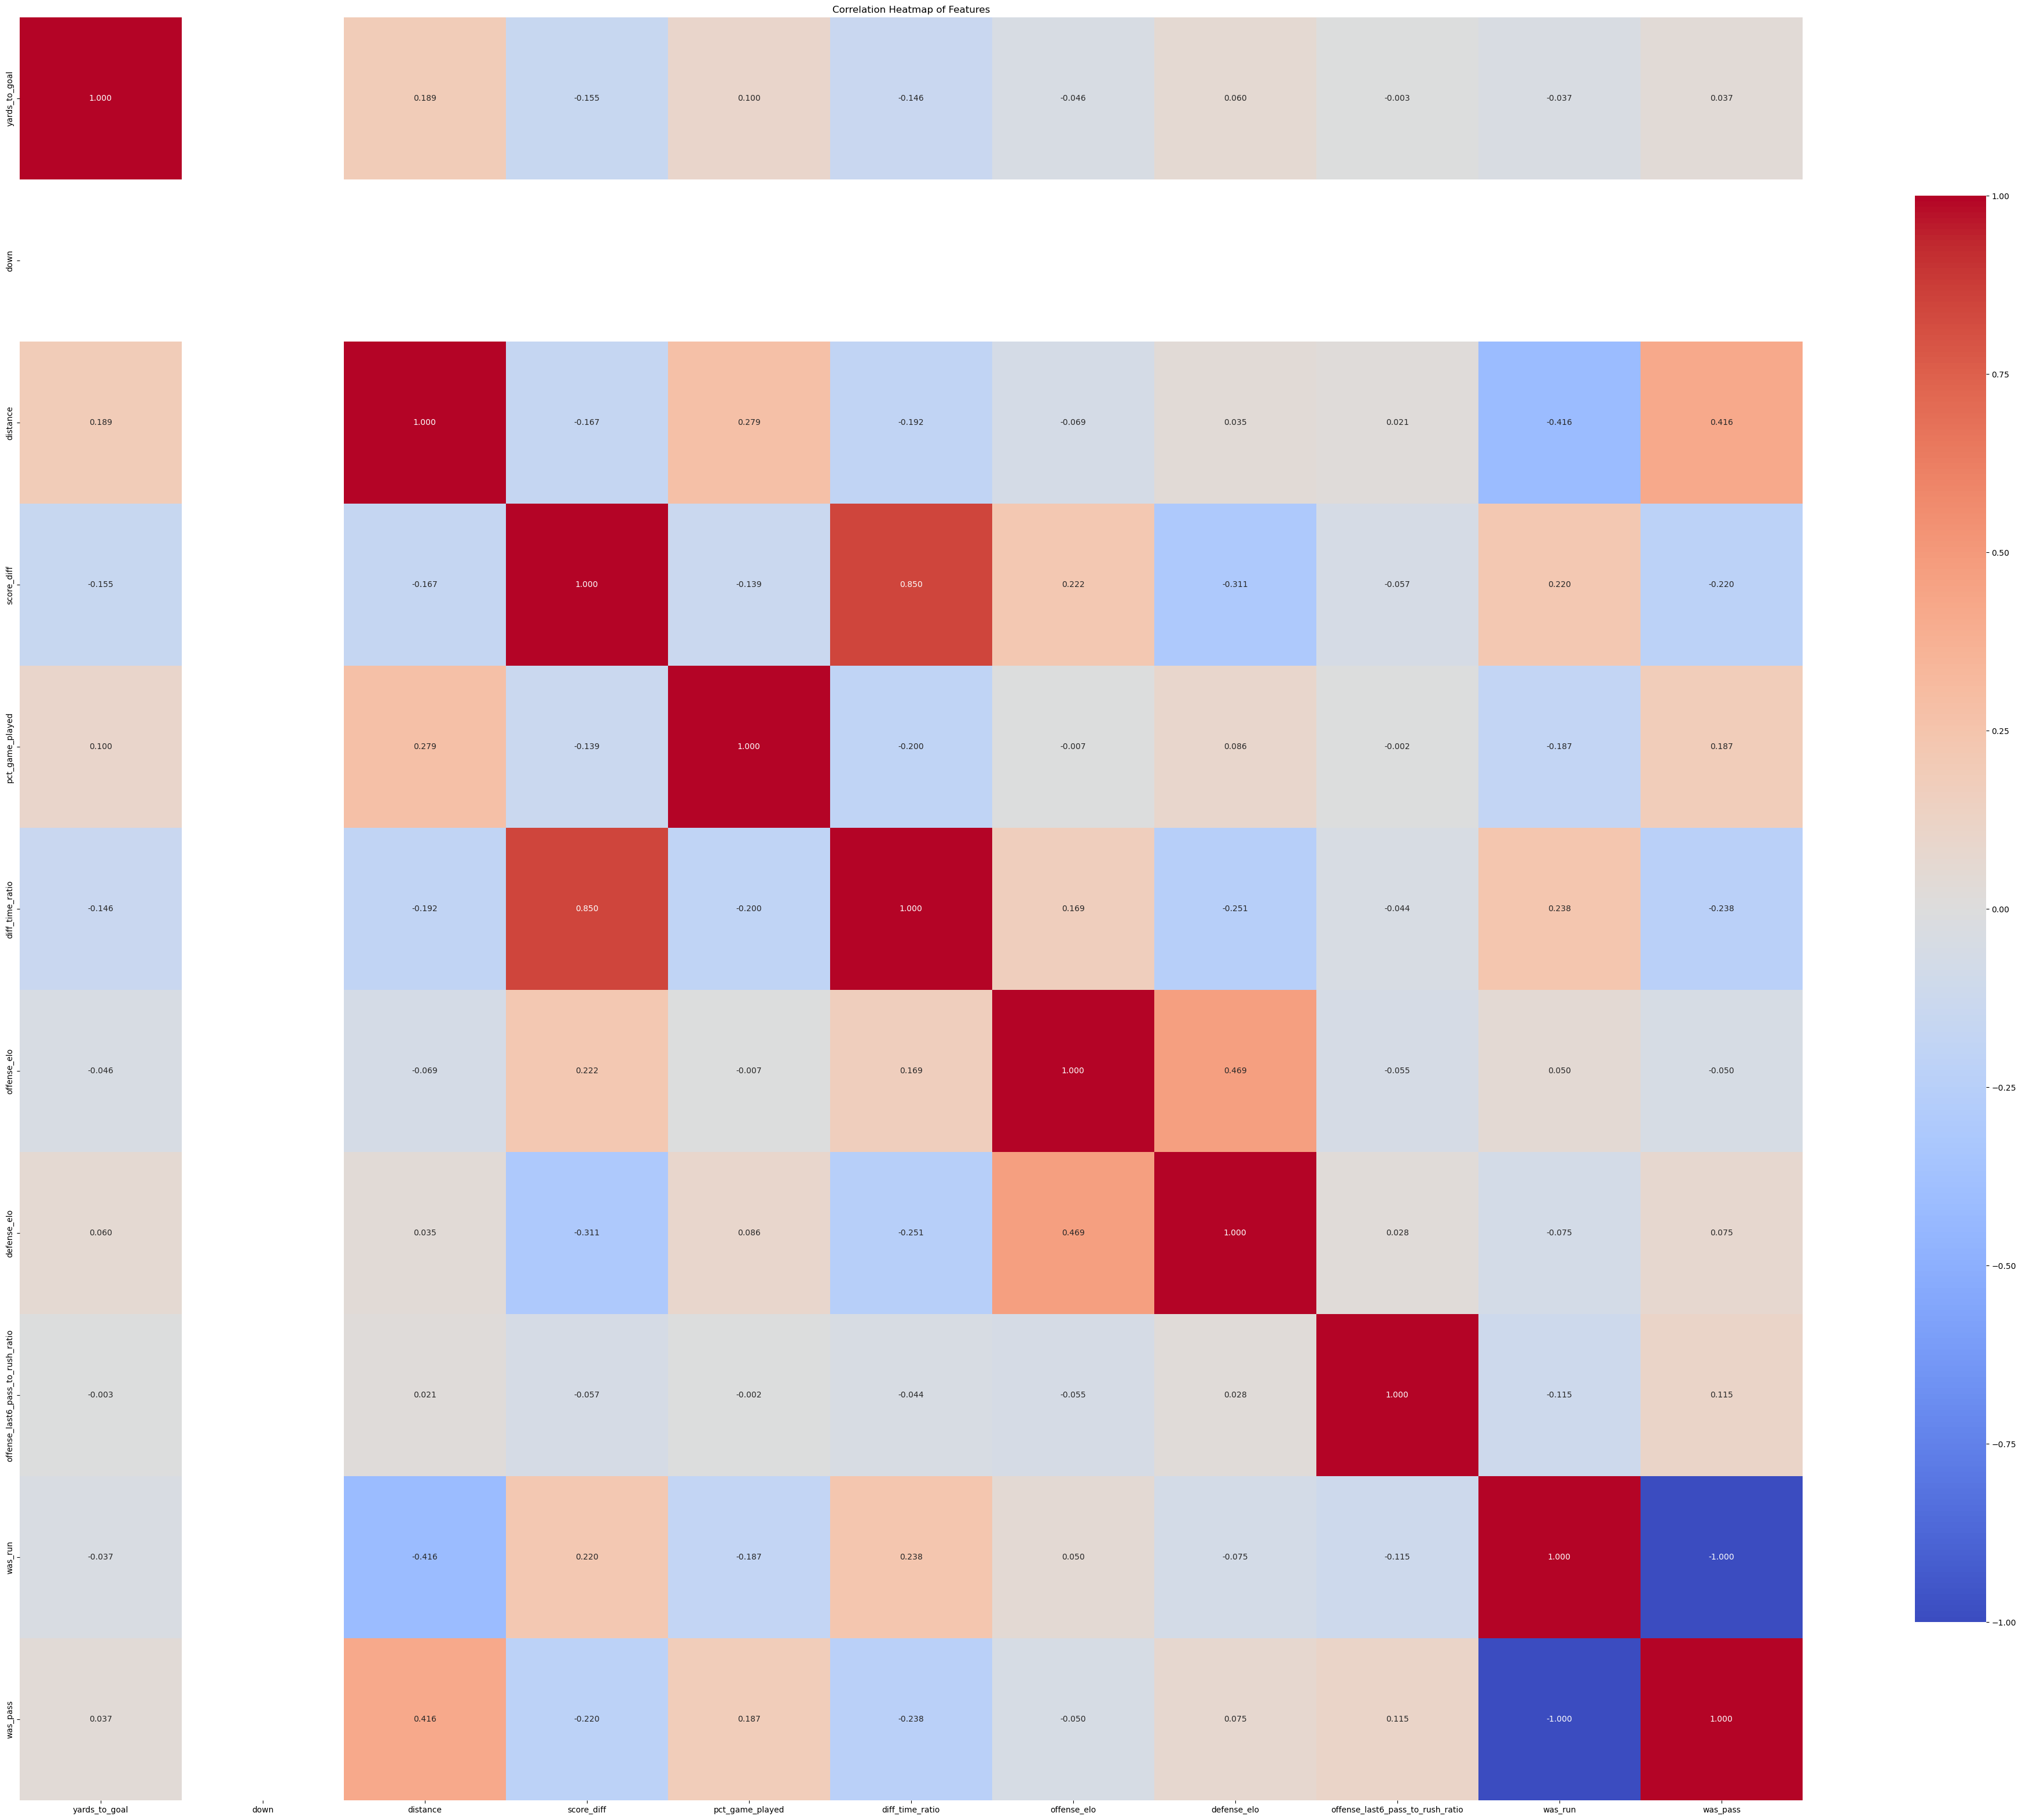

In [23]:
# correlation heatmap
plt.figure(figsize=(50, 40))
sns.heatmap(
    decisions[feature_names + ['was_run', 'was_pass']].corr(),
    annot=True, 
    fmt=".3f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [24]:
decisions.play_decision.value_counts(normalize=True)

play_decision
0    0.50727
1    0.49273
Name: proportion, dtype: float64

In [25]:
len(train_x) / (4 * np.bincount(train_y))

array([0.49281111, 0.50740174])

In [26]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
    
    # Calculate multiclass log loss
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="4th_down_go_deciosion",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(
    lambda trial: objective(trial, dtrain, dvalid), 
    n_trials=50,
    show_progress_bar=True
)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

  0%|          | 0/50 [00:00<?, ?it/s]

Number of boosted rounds: 81


In [27]:
from sklearn.metrics import accuracy_score, f1_score, log_loss

# Helper to compute all metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_proba = final_model.predict(dmatrix)
    y_pred = (y_proba >= 0.5).astype(int)

    bal_acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    ce_loss = log_loss(y_true, y_proba)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Accuracy : {bal_acc:.4f}")
    print(f"Macro F1 Score    : {macro_f1:.4f}")
    print(f"Log Loss          : {ce_loss:.4f}")

# Evaluate each split
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)


=== TRAIN SET METRICS ===
Accuracy : 0.8390
Macro F1 Score    : 0.8388
Log Loss          : 0.3801

=== VALIDATION SET METRICS ===
Accuracy : 0.8152
Macro F1 Score    : 0.8150
Log Loss          : 0.4233

=== TEST SET METRICS ===
Accuracy : 0.7998
Macro F1 Score    : 0.7996
Log Loss          : 0.4569


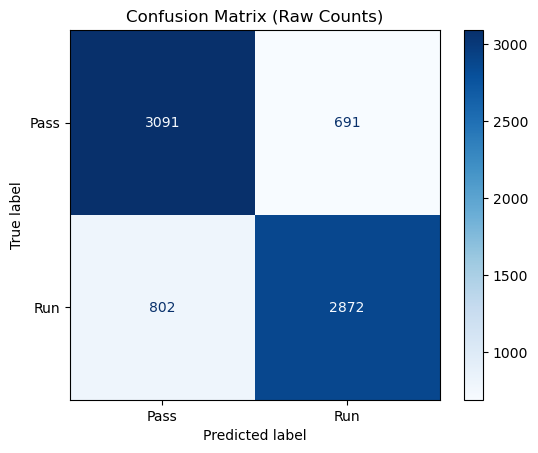

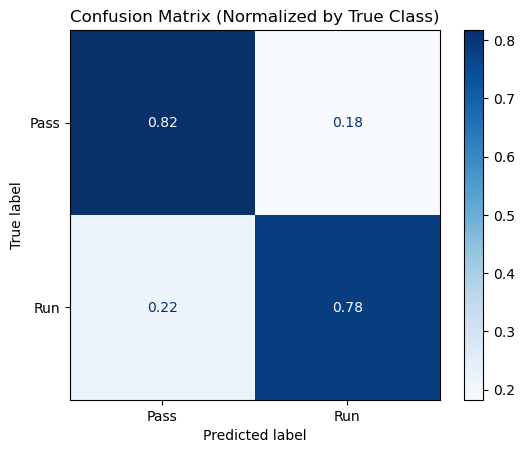

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = ['Pass', 'Run']

# Get predicted labels on test set
dtest = xgb.DMatrix(test_x)
y_test_proba = final_model.predict(dtest)
y_test_pred = y_test_proba >= 0.5
y_test_pred = y_test_pred.astype(int)

# Compute confusion matrix
cm = confusion_matrix(test_y, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot non-normalized
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Raw Counts)")
plt.show()

# Plot normalized by true labels (per-class recall)
cm_normalized = confusion_matrix(test_y, y_test_pred, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp_norm.plot(cmap='Blues', values_format=".2f")
plt.title("Confusion Matrix (Normalized by True Class)")
plt.show()

In [29]:
from sklearn.dummy import DummyClassifier

# Fit a dummy classifier that always predicts class probabilities
dummy = DummyClassifier(strategy="prior")
dummy.fit(train_x, train_y)  # train_y should be encoded (0, 1, 2, 3)

# Evaluate on test set
dummy_probs = dummy.predict_proba(test_x)
dummy_bal_acc = accuracy_score(test_y, dummy.predict(test_x))
dummy_macro_f1 = f1_score(test_y, dummy.predict(test_x), average='macro')
dummy_ce_loss = log_loss(test_y, dummy_probs) 

print("\n=== DUMMY CLASSIFIER METRICS ===")
print(f"Balanced Accuracy : {dummy_bal_acc:.4f}")
print(f"Macro F1 Score    : {dummy_macro_f1:.4f}")
print(f"Log Loss          : {dummy_ce_loss:.4f}")


=== DUMMY CLASSIFIER METRICS ===
Balanced Accuracy : 0.5072
Macro F1 Score    : 0.3365
Log Loss          : 0.6930


In [30]:
class_probas = final_model.predict(xgb.DMatrix(decisions[feature_names]))

decisions['run_proba'] = class_probas
decisions['pass_proba'] = 1 - class_probas

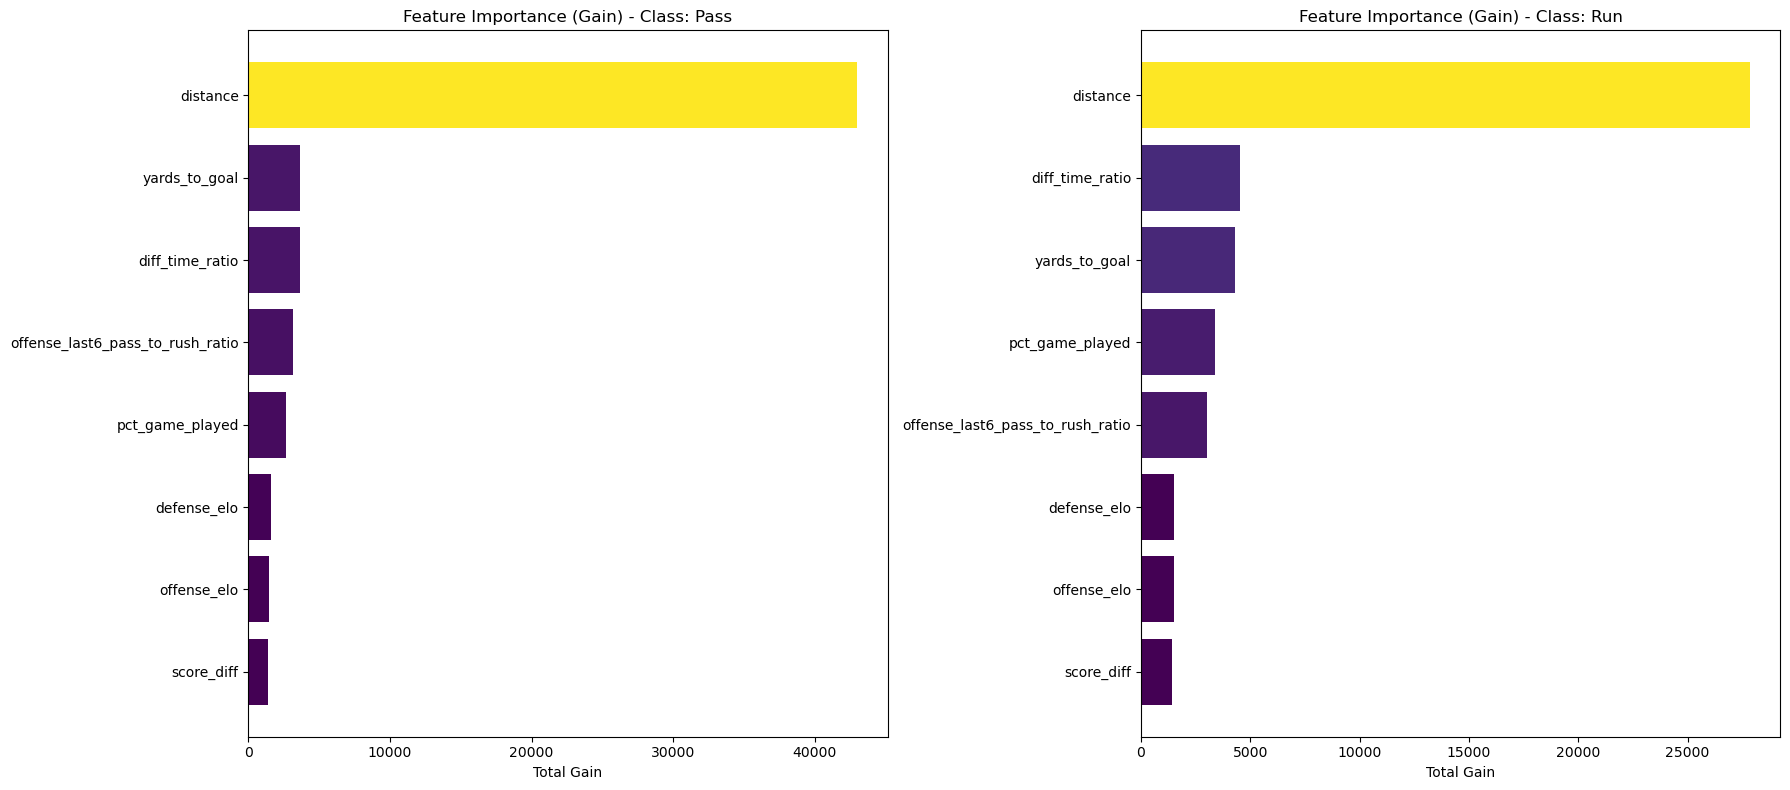

In [31]:
import matplotlib.cm as cm

num_classes = 2
class_names = ['Pass', 'Run']
trees_df = final_model.trees_to_dataframe()

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for class_id in range(num_classes):
    class_trees = trees_df[trees_df['Tree'] % num_classes == class_id]
    class_gain = (
        class_trees[class_trees['Feature'] != 'Leaf']
        .groupby('Feature')['Gain']
        .sum()
        .sort_values(ascending=False)
    )
    top_features = class_gain[:20]
    norm = plt.Normalize(top_features.min(), top_features.max())
    colors = cm.viridis(norm(top_features.values))

    ax = axes[class_id]
    ax.barh(top_features.index, top_features.values, color=colors)
    ax.set_title(f"Feature Importance (Gain) - Class: {class_names[class_id]}")
    ax.invert_yaxis()
    ax.set_xlabel("Total Gain")

plt.tight_layout()
plt.show()


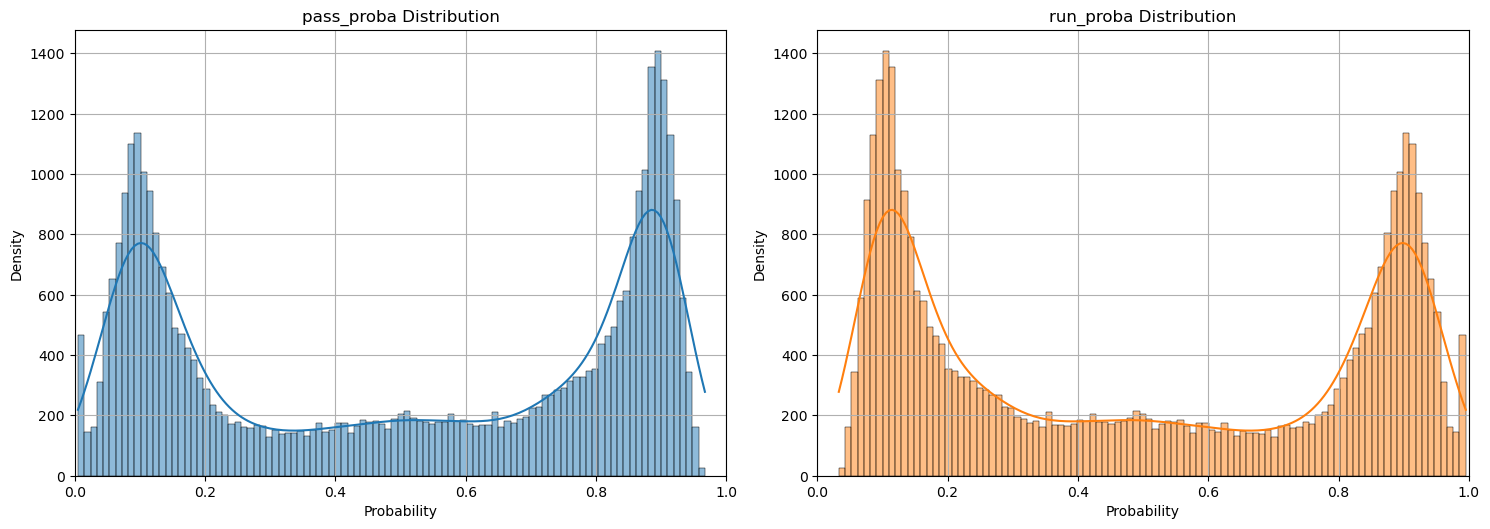

In [32]:
def plot_multiclass_probas(df, proba_cols=['pass_proba', 'run_proba']):
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(proba_cols, 1):
        plt.subplot(2, 2, i)  # 2x2 grid of plots
        sns.histplot(df[col], bins=100, kde=True, color=f'C{i-1}')
        plt.title(f'{col} Distribution')
        plt.xlabel('Probability')
        plt.ylabel('Density')
        plt.grid(True)
        plt.xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

plot_multiclass_probas(decisions)

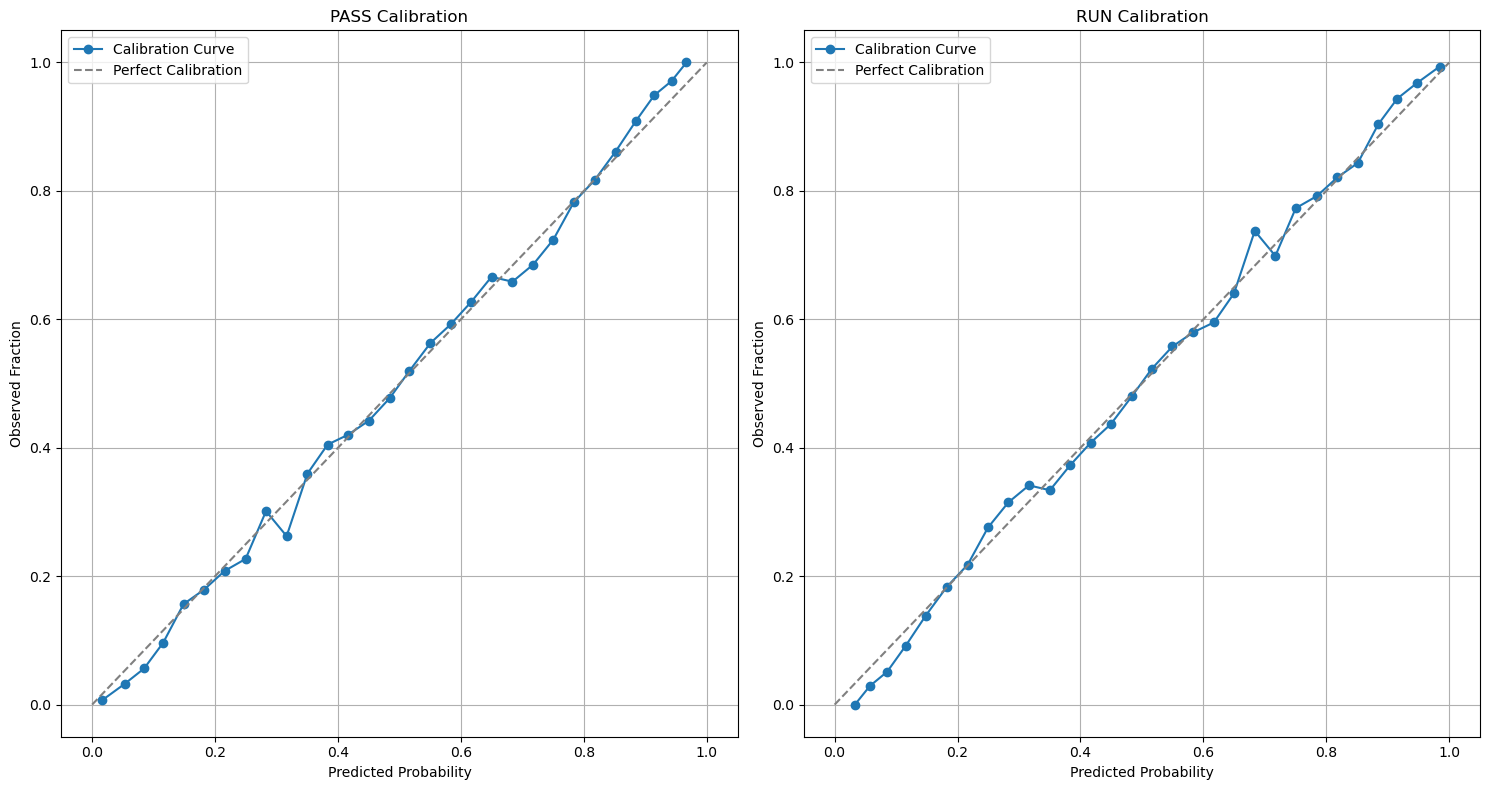

In [33]:
def plot_multiclass_calibration(df, proba_cols, actual_cols, bins=30):
    """
    Plots calibration curves for multiple classes in subplots.
    
    Args:
        df: DataFrame containing predicted probabilities and actual outcomes
        proba_cols: List of predicted probability columns (e.g., ['pass_proba', 'run_proba', ...])
        actual_cols: List of actual outcome columns (should be binary 0/1 for each class)
        bins: Number of bins for calibration
    """
    plt.figure(figsize=(15, 8))
    
    for i, (proba_col, actual_col) in enumerate(zip(proba_cols, actual_cols), 1):
        plt.subplot(1, 2, i)
        
        df['proba_bin'] = pd.cut(df[proba_col], 
                                bins=np.linspace(0, 1, bins + 1),
                                labels=False, 
                                include_lowest=True)
        
        calibration = df.groupby('proba_bin').agg(
            predicted_proba=(proba_col, 'mean'),
            actual_proba=(actual_col, 'mean'),
            count=(proba_col, 'size')
        ).reset_index()
        
        plt.plot(calibration['predicted_proba'], calibration['actual_proba'], 
                'o-', label='Calibration Curve')
        plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
        
        plt.title(f'{proba_col.replace("_proba", "").upper()} Calibration')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Observed Fraction')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_multiclass_calibration(
    df=decisions,
    proba_cols=['pass_proba', 'run_proba'],
    actual_cols=['was_pass', 'was_run'],
    bins=30
)

In [34]:
model_dir = join('../models/raw', 'decision')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"fourth_down_go_decision_classifier_xgb.bin")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../models/raw/decision' folder.


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_96307/1840365481.py:6: UserWarning: [15:00:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  final_model.save_model(model_path)
